### Imports

In [ ]:
# Misc
from IPython import get_ipython
from IPython.display import display
import hashlib
import os
from pprint import pprint
from time import monotonic
import ipywidgets as widgets
import sys
from tabulate import tabulate
from rich import print
from rich.console import Console
from rich.table import Table

# Data Wrangling
import pandas as pd
import numpy as numpy

# Data Manipulation
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import torch
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
import networkx as nx

src_path = os.path.abspath(os.path.join(os.getcwd(), "../../../src"))
sys.path.append(src_path)
from helpers import currency

from helpers import notebook

notebook.add_cell_timer()


# Machine Learning 
from sklearn.ensemble import RandomForestClassifier
import torch.nn.functional as F
import torch.nn as nn
from torch_geometric.nn import GCNConv, GATConv
import xgboost as xgb

# Result Metrics
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_curve, average_precision_score, precision_score, recall_score
from sklearn.metrics import roc_curve, roc_auc_score, auc
from sklearn.metrics import confusion_matrix
from sklearn.metrics import log_loss, matthews_corrcoef, balanced_accuracy_score


⏱️ Execution time: 0.01s


### Pipeline

In [ ]:
class model_pipeline:
    def __init__(self, df_path):
        """Initialize pipeline with dataset"""

        self.df = pd.read_csv(df_path)
    
    def df_summary(self):
        """Print dataset summary"""

        print("DATA HEAD")

        display(self.df.head())

        print("\nFEATURE TYPE")
        display(self.df.info())

    def add_date_features(self, date_column="Timestamp"):
        """Extract date features"""
        
        self.df['Timestamp'] = pd.to_datetime(self.df['Timestamp'])
        self.df['year'] = self.df['Timestamp'].dt.year  
        self.df['month'] = self.df['Timestamp'].dt.month  
        self.df['day'] = self.df['Timestamp'].dt.day  
        self.df['hour'] = self.df['Timestamp'].dt.hour
        self.df['minute'] = self.df['Timestamp'].dt.minute
        self.df['second'] = self.df['Timestamp'].dt.second 
        self.df.drop(columns=['Timestamp'], inplace= True)

    def apply_label_encoding(self, categorical_features):

        """Label encode categorical columns"""
        for col in categorical_features:
            self.df[col] = LabelEncoder().fit_transform(self.df[col])
    
    def extract_graph_features(self, weight_col):
        """Generate graph-based neighborhood context features"""

        G = nx.DiGraph()
        for _, row in self.df.iterrows():
            G.add_edge(row["Account"], row["Account.1"], weight=row[weight_col])

        # Add centrality and pagerank as features
        self.df["degree_centrality"] = self.df["Account"].map(nx.degree_centrality(G))
        self.df["pagerank"] = self.df["Account"].map(nx.pagerank(G))

    def generate_tensors(self, edge_features, edges = ["Account", "Account.1"]):
        """Convert data to PyTorch tensor format for GNNs"""

        def create_pyg_data(X, y):
            node_features = torch.tensor(X[edge_features].values, dtype=torch.float)

            labels = torch.tensor(y.values, dtype=torch.long)

            edge_index = torch.tensor(X[edges].values.T, dtype=torch.long)
            
            return Data(x=node_features, edge_index=edge_index, y=labels)

        # Create PyTorch Geometric datasets for train, validation, and test
        self.train_data = create_pyg_data(self.X_train, self.y_train)
        self.val_data = create_pyg_data(self.X_val, self.y_val)
        self.test_data = create_pyg_data(self.X_test, self.y_test)

        return self.train_data, self.val_data, self.test_data

    def split_train_test(self, X_cols, y_col, test_size=0.2):
        """Perform Train-Test Split"""

        X = self.df[X_cols]
        y = self.df[y_col]
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(
            X, y, test_size=test_size, random_state=42, stratify=y
        )

        return self.X_train, self.X_test, self.y_train, self.y_test

    def split_train_test_val(self, X_cols, y_col, test_size=0.2, val_size=0.1):
        """Perform Train-Test-Validation Split"""

        X = self.df[X_cols]
        y = self.df[y_col]
        
        self.X_train, X_temp, self.y_train, y_temp = train_test_split(
            X, y, test_size=(test_size + val_size), random_state=42, stratify=y
        )
        self.X_val, self.X_test, self.y_val, self.y_test = train_test_split(
            X_temp, y_temp, test_size=test_size / (test_size + val_size), random_state=42, stratify=y_temp
        )
        
        return self.X_train, self.X_val, self.X_test, self.y_train, self.y_val, self.y_test

    def result_metrics_train_test_split(self, y_test, y_pred, y_proba=None, class_labels=None):
        """
        Compute and display model performance metrics.

        Parameters:
        - y_test: True labels
        - y_pred: Predicted labels
        - y_proba: Predicted probabilities (for AUC-ROC & PR curve)
        - class_labels: List of class names (default: inferred from y_test)

        Returns:
        - metrics_dict: Dictionary containing key evaluation metrics
        """

        print("Classification Report:")
        print(classification_report(y_test, y_pred, digits=4))

        # Confusion Matrix
        cm = confusion_matrix(y_test, y_pred)
        accuracy = balanced_accuracy_score(y_test, y_pred)
        mcc = matthews_corrcoef(y_test, y_pred)
        logloss = log_loss(y_test, y_proba) if y_proba is not None else None

        print(f"Balanced Accuracy: {accuracy:.4f}")
        print(f"Matthews Correlation Coefficient (MCC): {mcc:.4f}")
        if logloss:
            print(f"Log Loss: {logloss:.4f}")

        # If class labels are not provided, generate default ones
        if class_labels is None:
            class_labels = [f"Class {i}" for i in range(len(set(y_test)))]

        # If probability predictions exist, compute ROC & PR AUC
        if y_proba is not None:
            # Binary classification
            if len(y_proba.shape) == 1:
                fpr, tpr, _ = roc_curve(y_test, y_proba)
                roc_auc = roc_auc_score(y_test, y_proba)
                precision, recall, _ = precision_recall_curve(y_test, y_proba)
                pr_auc = auc(recall, precision)
            else:  # Multi-class case
                fpr, tpr, _ = roc_curve(y_test, y_proba[:, 1])
                roc_auc = roc_auc_score(y_test, y_proba[:, 1])
                precision, recall, _ = precision_recall_curve(y_test, y_proba[:, 1])
                pr_auc = auc(recall, precision)


            print(f"AUC-ROC Score: {roc_auc:.4f}")
            print(f"Precision-Recall AUC: {pr_auc:.4f}")

        # Visualization
        fig, axes = plt.subplots(1, 3, figsize=(18, 5))

        # Confusion Matrix Plot
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", ax=axes[0])
        axes[0].set_title("Confusion Matrix")
        axes[0].set_xlabel("Predicted Label")
        axes[0].set_ylabel("True Label")
        axes[0].set_xticklabels(class_labels)
        axes[0].set_yticklabels(class_labels)

        # ROC Curve Plot
        if y_proba is not None:
            axes[1].plot(fpr, tpr, label=f'ROC AUC = {roc_auc:.4f}')
            axes[1].plot([0, 1], [0, 1], linestyle="--", color="gray")  # Baseline
            axes[1].set_title("ROC Curve")
            axes[1].set_xlabel("False Positive Rate")
            axes[1].set_ylabel("True Positive Rate")
            axes[1].legend()

            # Precision-Recall Curve
            axes[2].plot(recall, precision, label=f'PR AUC = {pr_auc:.4f}')
            axes[2].set_title("Precision-Recall Curve")
            axes[2].set_xlabel("Recall")
            axes[2].set_ylabel("Precision")
            axes[2].legend()

        plt.tight_layout()
        plt.show()

    def result_metrics(self, slide_title, y_train, y_train_pred, y_train_proba,
                       y_val, y_val_pred, y_val_proba,
                       y_test, y_test_pred, y_test_proba,
                       class_labels=None):
        """
        Compute and display model performance metrics for train, validation, and test sets.
        """

        def compute_metrics(y_true, y_pred, y_proba):
            """ Compute key classification metrics """
            cm = confusion_matrix(y_true, y_pred)
            accuracy = balanced_accuracy_score(y_true, y_pred)
            mcc = matthews_corrcoef(y_true, y_pred)
            logloss = log_loss(y_true, y_proba) if y_proba is not None else None
            precision = precision_score(y_true, y_pred, average='binary')
            recall = recall_score(y_true, y_pred, average='binary')

            if y_proba is not None:
                fpr, tpr, _ = roc_curve(y_true, y_proba[:, 1] if len(y_proba.shape) > 1 else y_proba)
                roc_auc = roc_auc_score(y_true, y_proba[:, 1] if len(y_proba.shape) > 1 else y_proba)
                precision_curve, recall_curve, _ = precision_recall_curve(y_true, y_proba[:, 1] if len(y_proba.shape) > 1 else y_proba)
                pr_auc = auc(recall_curve, precision_curve)
            else:
                fpr, tpr, roc_auc, precision_curve, recall_curve, pr_auc = None, None, None, None, None, None

            return {
                "confusion_matrix": cm,
                "accuracy": accuracy,
                "mcc": mcc,
                "log_loss": logloss,
                "precision": precision,
                "recall": recall,
                "roc_curve": (fpr, tpr),
                "roc_auc": roc_auc,
                "precision_recall_curve": (precision_curve, recall_curve),
                "pr_auc": pr_auc
            }

        # Compute metrics for train, validation, and test sets
        train_metrics = compute_metrics(y_train, y_train_pred, y_train_proba)
        val_metrics = compute_metrics(y_val, y_val_pred, y_val_proba)
        test_metrics = compute_metrics(y_test, y_test_pred, y_test_proba)

        dataset_names = ["Train", "Validation", "Test"]
        metrics_dicts = [train_metrics, val_metrics, test_metrics]

        # Create figure for **3 rows, 4 columns**
        fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(24, 12))
        fig.suptitle(slide_title, fontsize=20, fontweight="bold")

        for i, (name, metrics) in enumerate(zip(dataset_names, metrics_dicts)):
            cm, roc_curve_vals, pr_curve_vals = metrics["confusion_matrix"], metrics["roc_curve"], metrics["precision_recall_curve"]

            # Confusion Matrix (Column 1)
            sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", ax=axes[i, 0])
            axes[i, 0].set_title(f"{name} Set - Confusion Matrix", fontsize=14, fontweight="bold")
            axes[i, 0].set_xlabel("Predicted Label", fontsize=12)
            axes[i, 0].set_ylabel("True Label", fontsize=12)

            # ROC Curve (Column 2)
            if metrics["roc_auc"] is not None:
                fpr, tpr = roc_curve_vals
                axes[i, 1].plot(fpr, tpr, label=f'ROC AUC = {metrics["roc_auc"]:.4f}')
                axes[i, 1].plot([0, 1], [0, 1], linestyle="--", color="gray")  # Baseline
                axes[i, 1].set_title(f"{name} Set - ROC Curve", fontsize=14, fontweight="bold")
                axes[i, 1].legend(fontsize=12)

            # Precision-Recall Curve (Column 3)
            if metrics["pr_auc"] is not None:
                precision, recall = pr_curve_vals
                axes[i, 2].plot(recall, precision, label=f'PR AUC = {metrics["pr_auc"]:.4f}')
                axes[i, 2].set_title(f"{name} Set - Precision-Recall Curve", fontsize=14, fontweight="bold")
                axes[i, 2].legend(fontsize=12)

            # Convert None values to "N/A" before formatting
            log_loss_value = f"{metrics['log_loss']:.4f}" if metrics["log_loss"] is not None else "N/A"
            roc_auc_value = f"{metrics['roc_auc']:.4f}" if metrics["roc_auc"] is not None else "N/A"
            pr_auc_value = f"{metrics['pr_auc']:.4f}" if metrics["pr_auc"] is not None else "N/A"

            # Text-based Metrics (Column 4)
            metrics_text = (
                f"Balanced Accuracy: {metrics['accuracy']:.4f}\n"
                f"MCC: {metrics['mcc']:.4f}\n"
                f"Precision: {metrics['precision']:.4f}\n"
                f"Recall: {metrics['recall']:.4f}\n"
                f"Log Loss: {log_loss_value}\n"
                f"AUC-ROC: {roc_auc_value}\n"
                f"PR AUC: {pr_auc_value}"
            )
            axes[i, 3].text(0.1, 0.5, metrics_text, fontsize=14, ha="left", va="center", family="monospace", fontweight="bold")
            axes[i, 3].axis("off")  # Hide axis lines for text box

        plt.subplots_adjust(hspace=0.3, wspace=0.3)  # Better spacing for presentation
        plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout for title
        plt.show()
    


⏱️ Execution time: 0.01s

⏱️ Execution time: 0.01s


### Base XGBoost

In [8]:
xgb_pipeline = model_pipeline(df_path='/Users/abhitay/Developer/Columbia_projects/CAP/dsi-capstone-spring-2025-TD-anti-money-laundering/Code/Abhitay/IBM/HI-Small_Trans.csv')

# Feature Engineering
xgb_pipeline.add_date_features()
xgb_pipeline.apply_label_encoding(["Receiving Currency", "Payment Currency", "Payment Format", "Account.1", "Account"])
# pipeline.extract_graph_features(weight_col= 'Amount Paid')
xgb_pipeline.df

X_cols = ['Amount Received', 'Receiving Currency', 'Amount Paid', 'Payment Currency', 'Payment Format'
          ,'year', 'month', 'day', 'hour', 'minute', 'second']
y_col = 'Is Laundering'

# Train-Test-Validation Split
X_train, X_val, X_test, y_train, y_val, y_test = xgb_pipeline.split_train_test_val(
    X_cols= X_cols,
    y_col= y_col
)


⏱️ Execution time: 17.49s

⏱️ Execution time: 17.49s


In [9]:
params = {
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'max_depth': 8,
    'eta': 0.05,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'seed': 42
}

dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)
dval = xgb.DMatrix(X_val, label=y_val)

model = xgb.train(params, dtrain)

# Train predictions
train_proba = model.predict(dtrain)
train_pred = (train_proba > 0.5).astype(int)

# Validation predictions
val_proba = model.predict(dval)
val_pred = (val_proba > 0.5).astype(int)

# Test predictions
test_proba = model.predict(dtest)
test_pred = (test_proba > 0.5).astype(int)



⏱️ Execution time: 7.14s

⏱️ Execution time: 7.14s


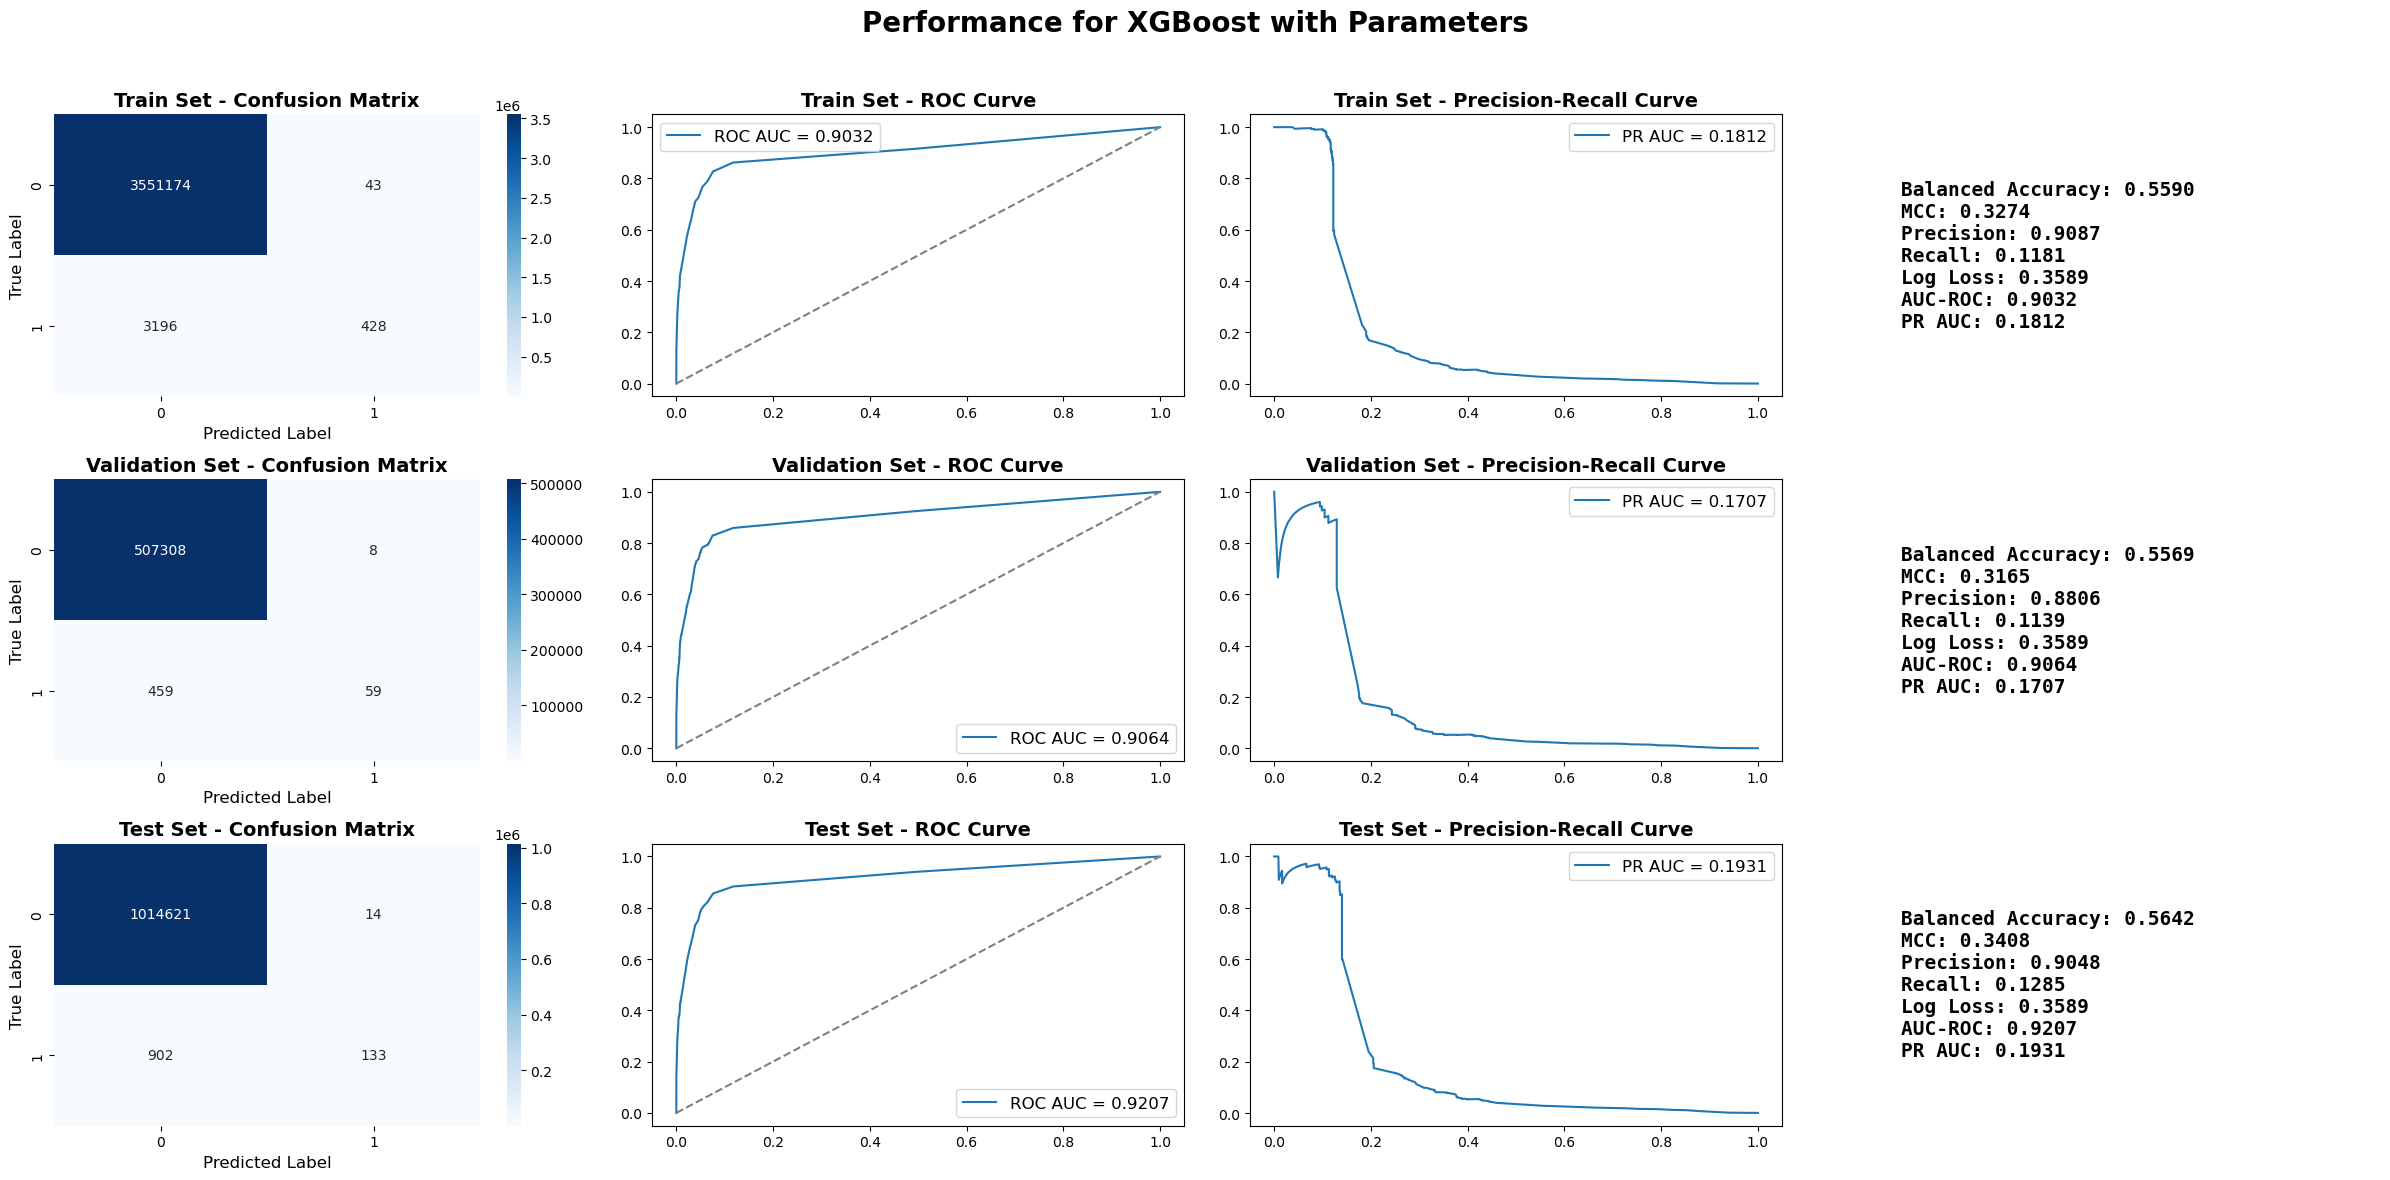


⏱️ Execution time: 9.35s

⏱️ Execution time: 9.35s


In [10]:

# Evaluate Model Performance

slide_title = "Performance for XGBoost with Parameters"
metrics_summary = xgb_pipeline.result_metrics(slide_title,
    y_train, train_pred, train_proba,
    y_val, val_pred, val_proba,
    y_test, test_pred, test_proba,
    class_labels=["Licit", "Illicit"]
)

### Simple GNN

In [13]:
gnn_pipeline = model_pipeline(df_path='/Users/abhitay/Developer/Columbia_projects/CAP/dsi-capstone-spring-2025-TD-anti-money-laundering/Code/Abhitay/IBM/HI-Small_Trans.csv')

# Feature Engineering
gnn_pipeline.add_date_features()
gnn_pipeline.apply_label_encoding(["Receiving Currency", "Payment Currency", "Payment Format", "Account.1", "Account"])
# pipeline.extract_graph_features(weight_col= 'Amount Paid')
gnn_pipeline.df

X_cols = ['Amount Received', 'Receiving Currency', 'Amount Paid', 'Payment Currency', 'Payment Format'
          ,'year', 'month', 'day', 'hour', 'minute', 'second', "Account.1", "Account"]
y_col = 'Is Laundering'

# Train-Test-Validation Split
X_train, X_val, X_test, y_train, y_val, y_test = gnn_pipeline.split_train_test_val(
    X_cols= X_cols,
    y_col= y_col
)
edge_features = ['Amount Received', 'Receiving Currency', 'Amount Paid', 'Payment Currency', 'Payment Format'
          ,'year', 'month', 'day', 'hour', 'minute', 'second']

edges = ["Account", "Account.1"]

train_data, val_data, test_data = gnn_pipeline.generate_tensors(edge_features= edge_features,edges = edges)

class SimpleGNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(SimpleGNN, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, output_dim)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)  # Activation Function
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)  # Log softmax for classification
    
# Instantiate the model
model = SimpleGNN(input_dim=train_data.x.shape[1], hidden_dim=16, output_dim=2)

# Define optimizer and loss function
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()

# Move data to device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
train_data = train_data.to(device)

# Training loop
epochs = 100
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    out = model(train_data.x, train_data.edge_index)
    loss = criterion(out, train_data.y)
    loss.backward()
    optimizer.step()
    
    if epoch % 10 == 0:
        print(f"Epoch {epoch} - Loss: {loss.item():.4f}")

# Move validation and test data to device
val_data = val_data.to(device)
test_data = test_data.to(device)

# Get predictions for Train, Validation, and Test
model.eval()
with torch.no_grad():
    # Train Set Predictions
    train_out = model(train_data.x, train_data.edge_index)
    train_proba = torch.exp(train_out).cpu().numpy()  # Convert log-softmax to probabilities
    train_pred = train_proba.argmax(axis=1)  # Get predicted class
    
    # Validation Set Predictions
    val_out = model(val_data.x, val_data.edge_index)
    val_proba = torch.exp(val_out).cpu().numpy()
    val_pred = val_proba.argmax(axis=1)

    # Test Set Predictions
    test_out = model(test_data.x, test_data.edge_index)
    test_proba = torch.exp(test_out).cpu().numpy()
    test_pred = test_proba.argmax(axis=1)

y_train_np = train_data.y.cpu().numpy()
y_val_np = val_data.y.cpu().numpy()
y_test_np = test_data.y.cpu().numpy()

# Evaluate Model Performance
slide_title = "Performance of GNN Model"

metrics_summary = gnn_pipeline.result_metrics(
    slide_title,
    y_train_np, train_pred, train_proba,
    y_val_np, val_pred, val_proba,
    y_test_np, test_pred, test_proba,
    class_labels=["Licit", "Illicit"]
)




⏱️ Execution time: 16.69s

⏱️ Execution time: 16.69s


### Architecture 1 GNN

Epoch 0 - Loss: 59592.1719

Epoch 10 - Loss: 1295.9913

Epoch 20 - Loss: 700.8773

Epoch 30 - Loss: 20.3938

Epoch 40 - Loss: 15.4689

Epoch 50 - Loss: 15.5242

Epoch 60 - Loss: 10.3028

Epoch 70 - Loss: 13.2889

Epoch 80 - Loss: 8.2972

Epoch 90 - Loss: 6.0204

/Users/abhitay/anaconda3/envs/def/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/abhitay/anaconda3/envs/def/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/abhitay/anaconda3/envs/def/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


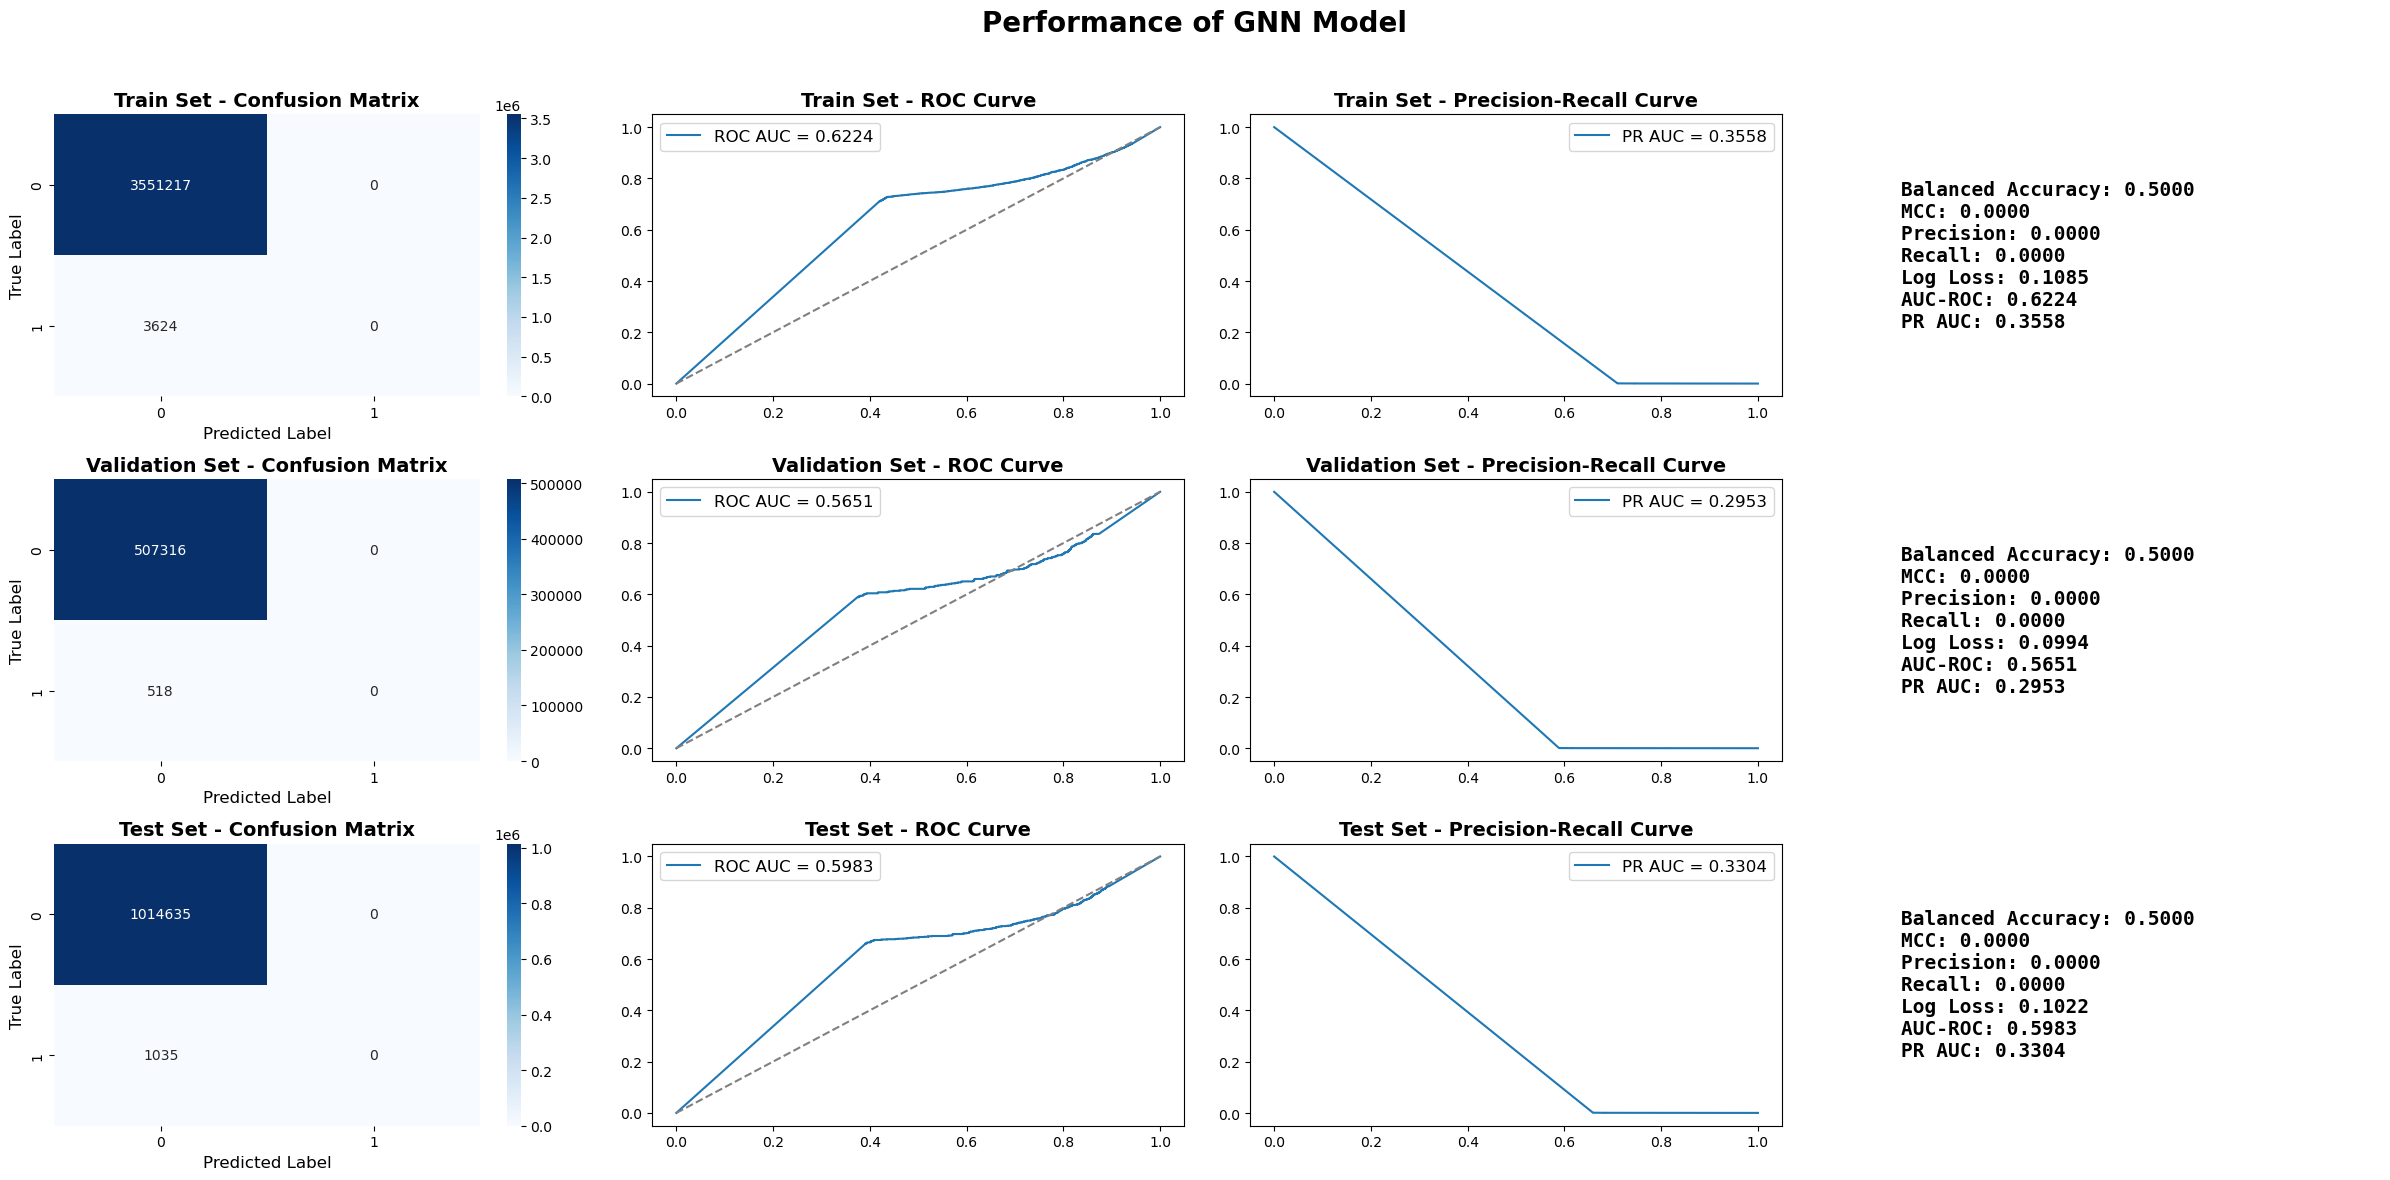


⏱️ Execution time: 876.98s

⏱️ Execution time: 876.98s


In [15]:
gnn1_pipeline = model_pipeline(df_path='/Users/abhitay/Developer/Columbia_projects/CAP/dsi-capstone-spring-2025-TD-anti-money-laundering/Code/Abhitay/IBM/HI-Small_Trans.csv')

# Feature Engineering
gnn1_pipeline.add_date_features()
gnn1_pipeline.apply_label_encoding(["Receiving Currency", "Payment Currency", "Payment Format", "Account.1", "Account"])
# pipeline.extract_graph_features(weight_col= 'Amount Paid')
gnn1_pipeline.df

X_cols = ['Amount Received', 'Receiving Currency', 'Amount Paid', 'Payment Currency', 'Payment Format'
          ,'year', 'month', 'day', 'hour', 'minute', 'second', "Account.1", "Account"]
y_col = 'Is Laundering'

# Train-Test-Validation Split
X_train, X_val, X_test, y_train, y_val, y_test = gnn1_pipeline.split_train_test_val(
    X_cols= X_cols,
    y_col= y_col
)
edge_features = ['Amount Received', 'Receiving Currency', 'Amount Paid', 'Payment Currency', 'Payment Format'
          ,'year', 'month', 'day', 'hour', 'minute', 'second']

edges = ["Account", "Account.1"]

train_data, val_data, test_data = gnn1_pipeline.generate_tensors(edge_features= edge_features,edges = edges)

gnn1_pipeline
# Define the Enhanced GNN Model
class GNN_arch1(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, heads=4):
        super(GNN_arch1, self).__init__()

        # Initial Graph Convolutional Layer (GCN)
        self.gcn1 = GCNConv(input_dim, hidden_dim)

        # Graph Attention Layer (GAT)
        self.gat1 = GATConv(hidden_dim, hidden_dim, heads=heads, concat=False)

        # Fully Connected Layer for Node Classification
        self.fc1 = nn.Linear(hidden_dim, hidden_dim // 2)
        self.fc2 = nn.Linear(hidden_dim // 2, output_dim)

        # Dropout for regularization
        self.dropout = nn.Dropout(0.3)

    def forward(self, x, edge_index):
        # Apply GCN
        x = self.gcn1(x, edge_index)
        x = F.relu(x)

        # Apply GAT for attention-based feature learning
        x = self.gat1(x, edge_index)
        x = F.relu(x)

        # Fully connected layers for **node-level classification**
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)

        return F.log_softmax(x, dim=1)  
    
# Instantiate the model
model = GNN_arch1(input_dim=train_data.x.shape[1], hidden_dim=16, output_dim=2)

# Define optimizer and loss function
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()

# Move data to device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
train_data = train_data.to(device)

# Training loop
epochs = 100
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    out = model(train_data.x, train_data.edge_index)
    loss = criterion(out, train_data.y)
    loss.backward()
    optimizer.step()
    
    if epoch % 10 == 0:
        print(f"Epoch {epoch} - Loss: {loss.item():.4f}")

# Move validation and test data to device
val_data = val_data.to(device)
test_data = test_data.to(device)

# Get predictions for Train, Validation, and Test
model.eval()
with torch.no_grad():
    # Train Set Predictions
    train_out = model(train_data.x, train_data.edge_index)
    train_proba = torch.exp(train_out).cpu().numpy()  # Convert log-softmax to probabilities
    train_pred = train_proba.argmax(axis=1)  # Get predicted class
    
    # Validation Set Predictions
    val_out = model(val_data.x, val_data.edge_index)
    val_proba = torch.exp(val_out).cpu().numpy()
    val_pred = val_proba.argmax(axis=1)

    # Test Set Predictions
    test_out = model(test_data.x, test_data.edge_index)
    test_proba = torch.exp(test_out).cpu().numpy()
    test_pred = test_proba.argmax(axis=1)

y_train_np = train_data.y.cpu().numpy()
y_val_np = val_data.y.cpu().numpy()
y_test_np = test_data.y.cpu().numpy()

# Evaluate Model Performance
slide_title = "Performance of GNN Model"

metrics_summary = gnn1_pipeline.result_metrics(
    slide_title,
    y_train_np, train_pred, train_proba,
    y_val_np, val_pred, val_proba,
    y_test_np, test_pred, test_proba,
    class_labels=["Licit", "Illicit"]
)

